# Investigate filtering of operational OSISAF SIC maps with edge maps

We investigate here the possibility to use the operational OSISAF ice edge (OSI-402) product as a filter for the OSISAF ice conc maps (OSI-402).

The ice_edge product are based mostly on the same instruments and channels as the ice concentration product, but use a slightly different approach to sort a satellite observation into 3 classes: open water, open ice, and closed ice. A desired featured of the sea ice edge algorithm is its general lower sensitivity to atmospheric noise. However, since it works only classes, it does detect true low concentration ice (roughly 0% - 30% concentration range) as open water.

Below are a set of python commands to test the approach, and investigates the consequences.

## Preparation

In [1]:
%pylab inline
import os
from netCDF4 import Dataset
import numpy as np
from matplotlib import pylab as plt
from datetime import date

Populating the interactive namespace from numpy and matplotlib


In [60]:
# some configuration for the demonstration
dt = date(2016,11,7)
area = 'nh'
ddir = '/home/thomasl/temp/'

In [43]:
# read sic and edge netCDF/CF products
sic_fname = os.path.join(ddir,'ice_conc_{}_polstere-100_multi_{:%Y%m%d}1200.nc'.format(area, dt))
sie_fname = sic_fname.replace('conc','edge')

with Dataset(sic_fname,"r") as _:
    sic = _.variables['ice_conc'][0,:]
with Dataset(sie_fname,"r") as _:
    sie = _.variables['ice_edge'][0,:]

## Filtering of OSI-401 by OSI-402

The filtering step is rather simple: everywhere OSI-402 (ice_edge) reports the "open_water" class (value 1 in the netCDF/CF file), we force OSI-401 (ice_conc) values to 0%. Since OSI-402 and OSI-401 do not share exactly the same masks (especially along the coasts), we enforce that the mask of OSI-401 (the FillValue grid cells) is not changed by the filtering step.

In [44]:
# apply ice_edge as an Open Water Filter onto the ice_conc variable
sicf = sic.copy()
sicf[sie==1] = 0
sicf.mask = sic.mask

## Analysis

In [53]:
def plot_maps(fig,sic,sie,sicf,zoom=None,):
    
    if zoom is None:
        shape = sic.shape
        y0 = 0
        y1 = shape[0]-1
        x0 = 0
        x1 = shape[1]-1
    else:
        y0,y1,x0,x1 = zoom
        
    # original SIC as in the OSISAF netCDF/CF products  
    ax = fig.add_subplot(1,3,1)
    conc_cm = cm.jet
    conc_cm.set_bad('grey')
    ax.imshow(sic[y0:y1,x0:x1],interpolation='nearest',vmin=0,vmax=100,cmap=conc_cm)
    ax.set_title('original SIC')
    
    # original SIEdge as in the OSISAF netCDF/CF products
    #ax = fig.add_subplot(1,3,2,sharex=ax,sharey=ax)
    #edge_cm = cm.Blues_r
    #edge_cm.set_bad('grey')
    #ax.imshow(sie[y0:y1,x0:x1],interpolation='nearest',cmap=edge_cm)
    #ax.set_title('SI Edge')
    
    # map of filtered SIC
    ax = fig.add_subplot(1,3,2,sharex=ax,sharey=ax)
    ax.imshow(sicf[y0:y1,x0:x1],interpolation='nearest',vmin=0,vmax=100,cmap=conc_cm)
    ax.set_title('Open Water Filtered SIC')
    
    # map of diffs
    ax = fig.add_subplot(1,3,3,sharex=ax,sharey=ax)
    diff_cm = cm.bwr
    diff_cm.set_bad('grey')
    diff_max = 40
    ax.imshow(sicf[y0:y1,x0:x1]-sic[y0:y1,x0:x1],interpolation='nearest',
              vmin=-diff_max,vmax=+diff_max,cmap=diff_cm)
    ax.set_title('Diff origSIC - owfSIC')
    
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig
    
def plot_hists(fig,sic,sicf,zoom=None,):
    
    if zoom is None:
        shape = sic.shape
        y0 = 0
        y1 = shape[0]-1
        x0 = 0
        x1 = shape[1]-1
    else:
        y0,y1,x0,x1 = zoom
        
    # original SIC as in the OSISAF netCDF/CF products  
    ax = fig.add_subplot(1,2,1,)
    sic_hist = sic[y0:y1,x0:x1]
    #sic_hist[sic_hist==0] = np.ma.masked
    ax.hist(sic_hist.compressed(),bins=20)
    ax.set_title('original SIC')
    
    # map of filtered SIC
    ax = fig.add_subplot(1,2,2,sharex=ax,sharey=ax)
    sicf_hist = sicf[y0:y1,x0:x1]
    #sicf_hist[sicf_hist==0] = np.ma.masked
    ax.hist(sicf_hist.compressed(),bins=20)
    ax.set_title('Open Water Filtered SIC')
    ax.set_xlabel('Sea Ice Concentration')
    ax.set_ylabel('Occurence (density)')
    ax.set_xlim(0,100)
    
    return fig

We look at maps and histograms for the SIC maps before and after the filtering is applied. We first look at maps of the whole hemisphere, then zoom over a Nothern Atlantic and a Pacific sector.

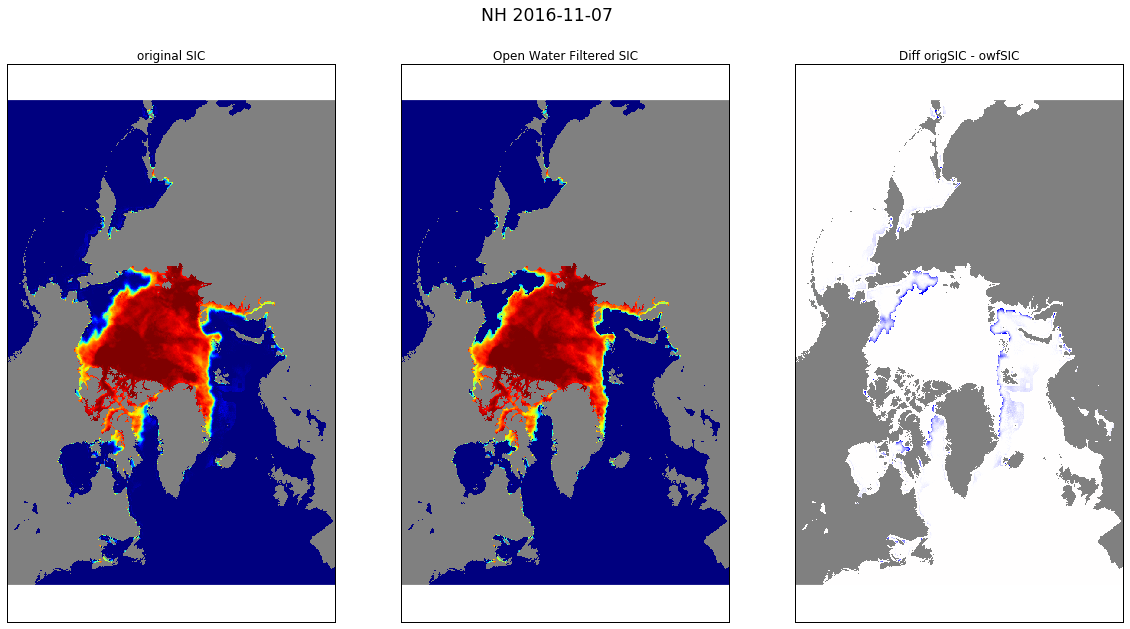

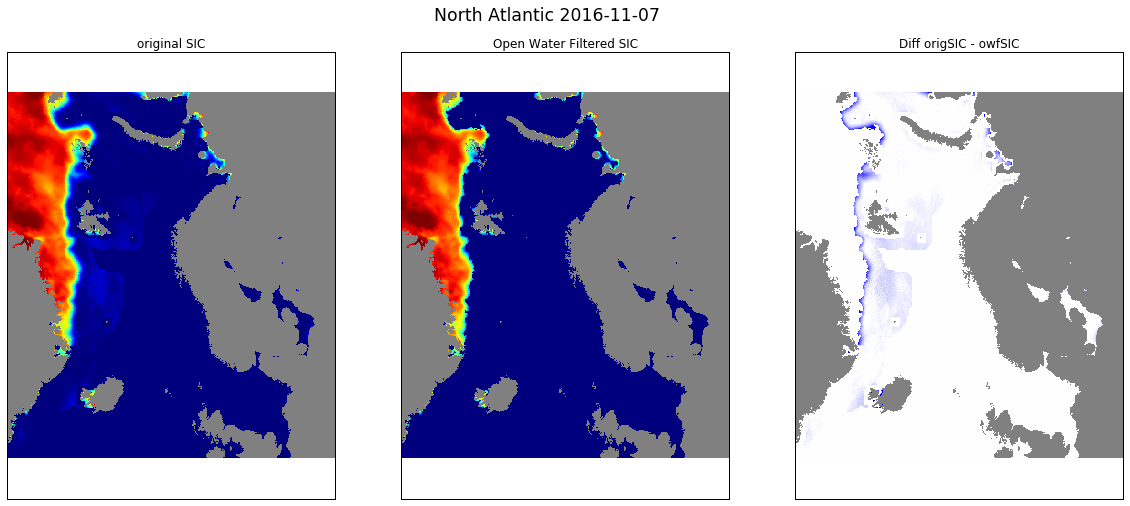

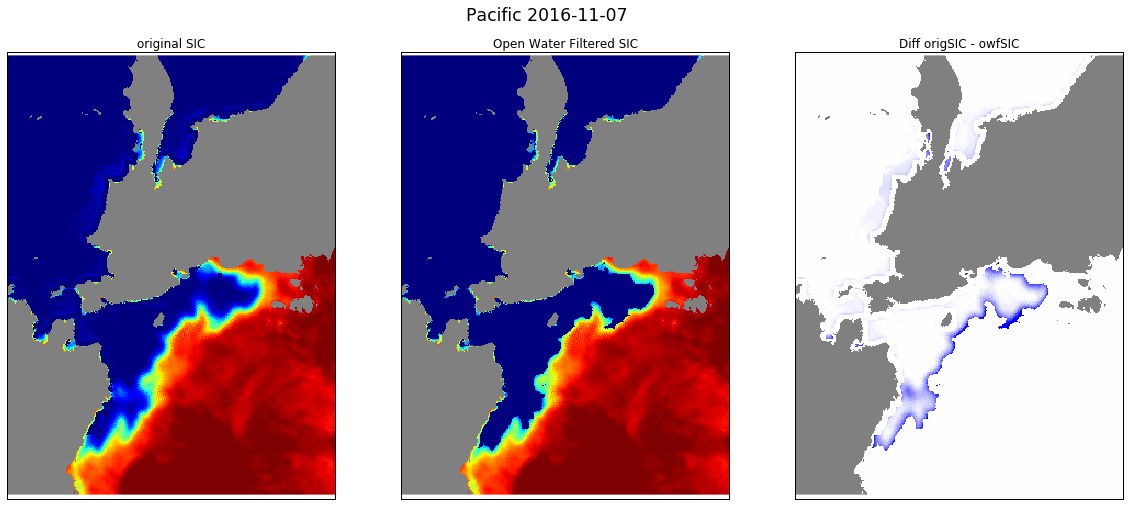

In [61]:
fig = plt.figure(figsize=(20,10))
fig = plot_maps(fig,sic,sie,sicf)
fig.suptitle('{} {:%Y-%m-%d}'.format(area.upper(),dt),fontsize='xx-large')
plt.show()

fig = plt.figure(figsize=(20,8))
fig = plot_maps(fig,sic,sie,sicf,zoom=(500,900,400,760))
fig.suptitle('North Atlantic {:%Y-%m-%d}'.format(dt),fontsize='xx-large')
plt.show()

fig = plt.figure(figsize=(20,8))
fig = plot_maps(fig,sic,sie,sicf,zoom=(200,600,100,400))
fig.suptitle('Pacific {:%Y-%m-%d}'.format(dt),fontsize='xx-large')
plt.show()

Histograms (just for the Atlantic and Pacific zooms) to assess how the distribution of values is affected.

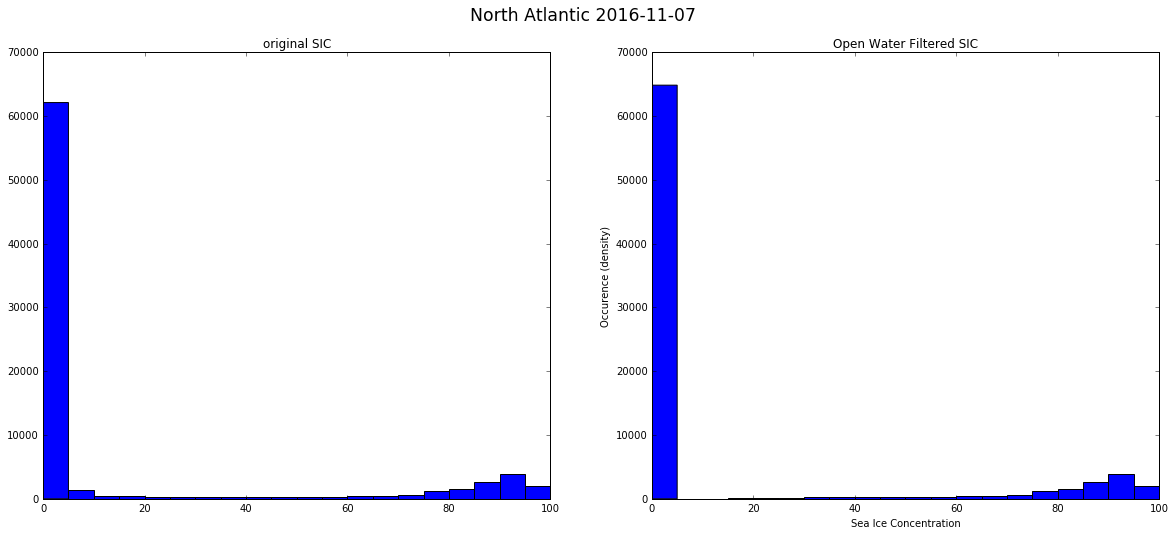

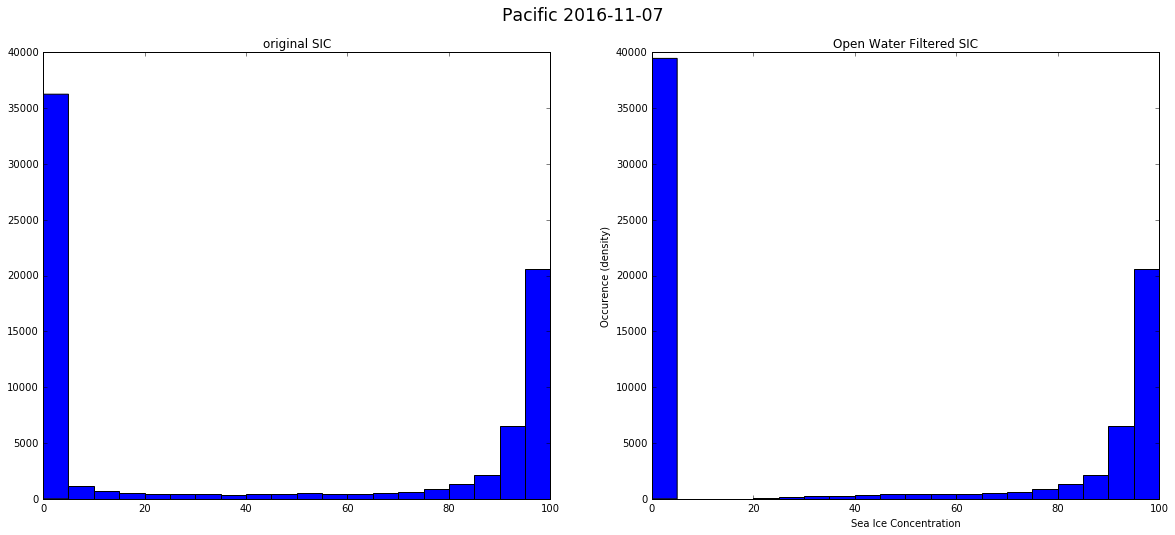

In [59]:
fig = plt.figure(figsize=(20,8))
fig = plot_hists(fig,sic,sicf,zoom=(500,900,400,760))
fig.suptitle('North Atlantic {:%Y-%m-%d}'.format(dt),fontsize='xx-large')
plt.show()

fig = plt.figure(figsize=(20,8))
fig = plot_hists(fig,sic,sicf,zoom=(200,600,100,400))
fig.suptitle('Pacific {:%Y-%m-%d}'.format(dt),fontsize='xx-large')
plt.show()

# Conclusions
This seems to work as expected. It does correct the false ice very close to land since the ice_edge product is not interpolated to the coast. We do observe that true, low-concentration ice is removed (and transferred to SIC=0% bin). The influence on the SIC distribution seems to be limited to the [0%;30%] range.